In [25]:
datafile_km = '../data/all_frames_wclust.pkl.xz' # with AU6_AU12 clusters
datafile_bmm = '../data/all_frames_clust.bmm.pkl.xz' # bmm with 5 clusters
datafile_bmm9 = '../data/all_frames_clust.bmm9.pkl.xz' # bmm clusters

CONFIDENCE_TOL = 0.90 # only use data with conf > this

#-----------------

import pandas as pd
import numpy as np
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.options.display.float_format = '{:,.4f}'.format
from IPython.display import display
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
# import in scripts dir
import sys
sys.path.append('../scripts')
import compare 

cluster_name2i = {'duchenne':0,'neutral':1,'strong duchenne':2,'6 only':3,'polite':4}
cluster_name2i_bmm9 = {'0':0,'1':1,'2':2,'3':3,'4':4,'5':5,'6':6,'7':7,'8':8}

def load_cluster_data(datafile):
    print('\n...loading cluster data: ', datafile)
    if 'pkl' in datafile:
        df = pd.read_pickle(datafile)
    else:
        df = pd.read_csv(datafile, skipinitialspace=True) 
    df = df[df['confidence'] >= CONFIDENCE_TOL]
    # confidence of .90 causes nfiles 302-->298

    if 'bmm9' in datafile:
        for cluster_name in cluster_name2i_bmm9.keys():
            df[cluster_name] = (df['AU06_AU12_cluster'] == cluster_name2i_bmm9[cluster_name]).astype(int)
    else:
        for cluster_name in cluster_name2i.keys():
            df[cluster_name] = (df['AU06_AU12_cluster'] == cluster_name2i[cluster_name]).astype(int)

    print('n:',df.shape[0])
    print('# files = ', df['Filename'].nunique())

    print('\ncolumns: ')
    for c in df.columns:
        print(c,end=',')
    print('-------')
    return df
        
df_kmm = load_cluster_data(datafile_km)
df_bmm = load_cluster_data(datafile_bmm)
df_bmm9 = load_cluster_data(datafile_bmm9)


...loading cluster data:  ../data/all_frames_wclust.pkl.xz
n: 1246319
# files =  298

columns: 
Filename,filetype,segment,timestamp,confidence,success,pose_Tx,pose_Ty,pose_Tz,pose_Rx,pose_Ry,pose_Rz,AU01_r,AU02_r,AU04_r,AU05_r,AU06_r,AU07_r,AU09_r,AU10_r,AU12_r,AU14_r,AU15_r,AU17_r,AU20_r,AU23_r,AU25_r,AU26_r,AU45_r,AU01_c,AU02_c,AU04_c,AU05_c,AU06_c,AU07_c,AU09_c,AU10_c,AU12_c,AU14_c,AU15_c,AU17_c,AU20_c,AU23_c,AU25_c,AU26_c,AU28_c,AU45_c,AU06_AU12_cluster,neutral,6 only,duchenne,polite,strong duchenne,-------

...loading cluster data:  ../data/all_frames_clust.bmm.pkl.xz
n: 1246319
# files =  298

columns: 
Filename,filetype,confidence,segment,timestamp,AU06_AU12_cluster,neutral,6 only,duchenne,polite,strong duchenne,-------

...loading cluster data:  ../data/all_frames_clust.bmm9.pkl.xz
n: 1246319
# files =  298

columns: 
Filename,filetype,confidence,segment,timestamp,AU06_AU12_cluster,5,8,6,2,1,3,0,4,7,-------


In [26]:
# pre-processing df and adding Gender
genderdat = '../data/old_data_gender.csv'
Gen_df=pd.read_csv(genderdat)

df_bmm = df_bmm[(df_bmm['segment']=='S2')& (df_bmm['filetype'].str.contains('W'))]
df_bmm9 = df_bmm9[(df_bmm9['segment']=='S2')& (df_bmm9['filetype'].str.contains('W'))]
df_kmm = df_kmm[(df_kmm['segment']=='S2')& (df_kmm['filetype'].str.contains('W'))]


df_bmm['root']=df_bmm['Filename'].str.split('-W').str[0]
df_bmm9['root']=df_bmm9['Filename'].str.split('-W').str[0]
df_kmm['root']=df_kmm['Filename'].str.split('-W').str[0]

dfGenbmm=pd.merge(df_bmm, Gen_df, how = 'left', left_on = 'root', right_on = 'root')
dfGenbmm9=pd.merge(df_bmm9, Gen_df, how = 'left', left_on = 'root', right_on = 'root')
dfGenkmm=pd.merge(df_kmm, Gen_df, how = 'left', left_on = 'root', right_on = 'root')

df_bmm_gr=pd.DataFrame(dfGenbmm.groupby(['root']).mean().dropna())
df_bmm9_gr=pd.DataFrame(dfGenbmm9.groupby(['root']).mean().dropna())
df_kmm_gr=pd.DataFrame(dfGenkmm.groupby(['root']).mean().dropna())


print(df_bmm_gr.shape)
print(df_bmm9_gr.shape)
print(df_kmm_gr.shape)

(143, 12)
(143, 16)
(143, 54)


In [5]:
def hist_stats(df_bmm_gr,feat):

    from scipy.stats import mannwhitneyu
    #feat = '6 only'
    a = df_bmm_gr[(df_bmm_gr['witness_is_male'] == 1) & (df_bmm_gr['describer_job_is_truth'] == 1)][feat]
    b = df_bmm_gr[(df_bmm_gr['witness_is_male'] == 1) & (df_bmm_gr['describer_job_is_truth'] == 0)][feat]
    s, p = mannwhitneyu(a,b)

    a.hist(alpha=.3, bins=40, color='green')
    b.hist(alpha=.3, bins=40, color='red')
    tit = feat + ', p = ' + str(p)
    plt.title(tit)

    plt.show()

    plt.subplot(1,2,1)
    pd.DataFrame(a).boxplot()
    plt.subplot(1,2,2)
    pd.DataFrame(b).boxplot()
    
    plt.show()

    #df_bmm_gr[(df_bmm_gr['witness_is_male'] == 1)][[feat] + ['describer_job_is_truth']].boxplot(by='describer_job_is_truth')

    print('TRUTH median: ', a.median())
    print('BLUFF median: ', b.median())
    print('TRUTH mean: ', a.mean())
    print('BLUFF mean: ', b.mean())

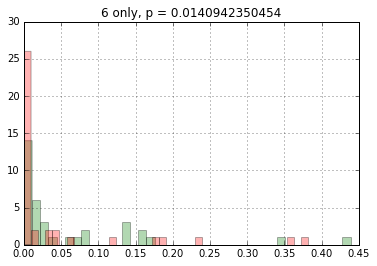

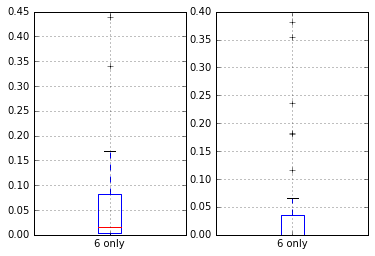

TRUTH median:  0.016602277698315564
BLUFF median:  0.0
TRUTH mean:  0.06157083395456283
BLUFF mean:  0.044480537532146515


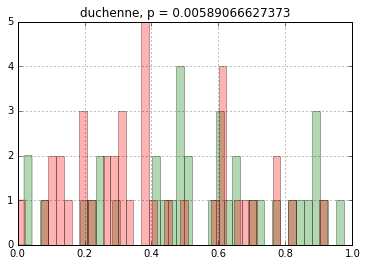

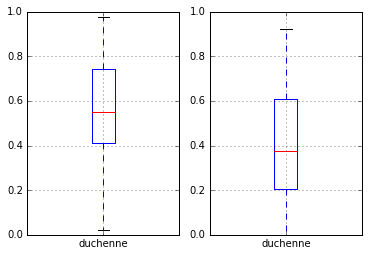

TRUTH median:  0.5519956739896306
BLUFF median:  0.3753351206434316
TRUTH mean:  0.5463797616974617
BLUFF mean:  0.3985840531766171


In [6]:
hist_stats(df_bmm_gr,'6 only')
hist_stats(df_bmm_gr,'duchenne')

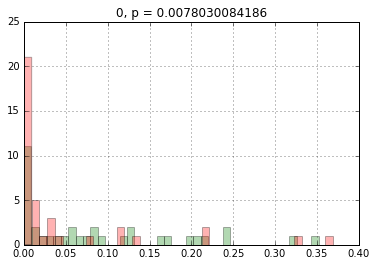

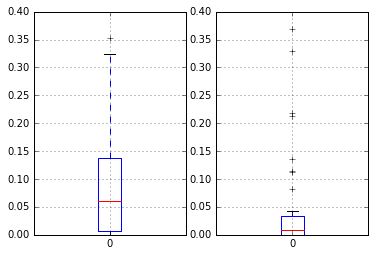

TRUTH median:  0.06046538258937774
BLUFF median:  0.008441558441558441
TRUTH mean:  0.08885928012302857
BLUFF mean:  0.047249748100896105


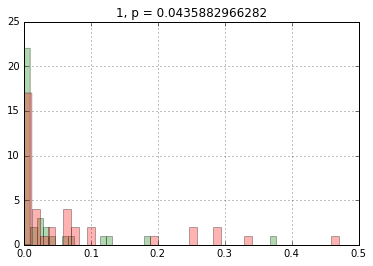

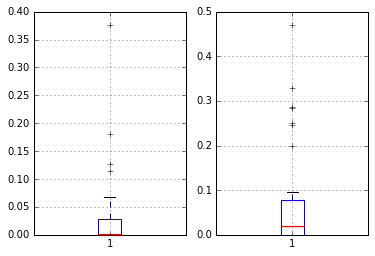

TRUTH median:  0.0012457121551081281
BLUFF median:  0.020023557126030624
TRUTH mean:  0.032474405940590034
BLUFF mean:  0.07383335861523195


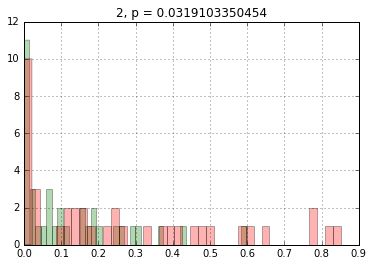

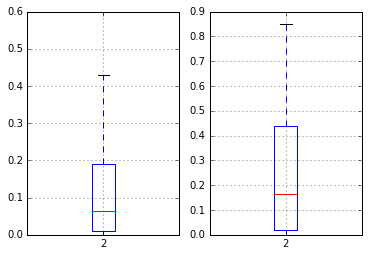

TRUTH median:  0.06522223459953214
BLUFF median:  0.16344916344916344
TRUTH mean:  0.12127917787935602
BLUFF mean:  0.2625716949883636


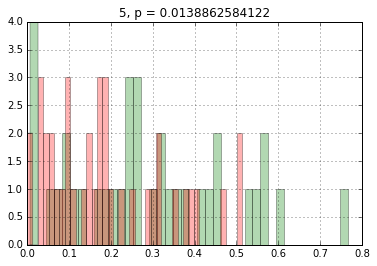

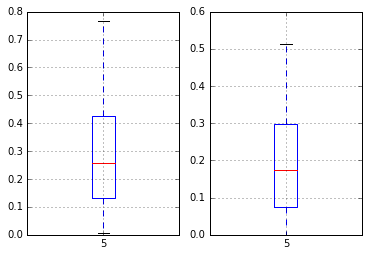

TRUTH median:  0.2575366063738157
BLUFF median:  0.17525773195876287
TRUTH mean:  0.2861344470293387
BLUFF mean:  0.19083226227229735


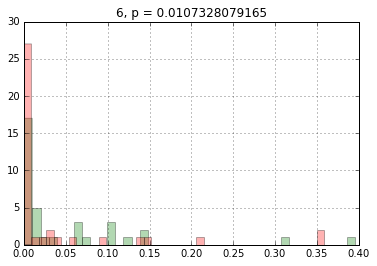

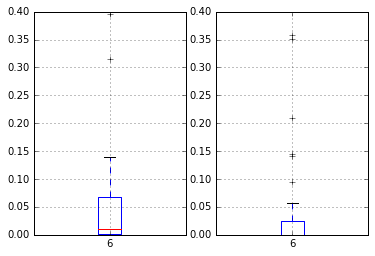

TRUTH median:  0.011207762557077625
BLUFF median:  0.0
TRUTH mean:  0.05188885838262804
BLUFF mean:  0.03916890176184352


In [7]:
hist_stats(df_bmm9_gr,'0')
hist_stats(df_bmm9_gr,'1')
hist_stats(df_bmm9_gr,'2')
hist_stats(df_bmm9_gr,'5')
hist_stats(df_bmm9_gr,'6')

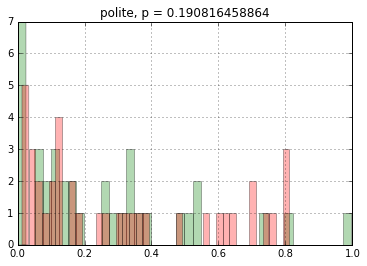

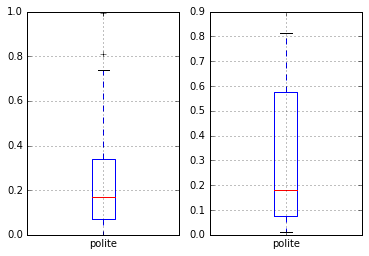

TRUTH median:  0.16888515630791212
BLUFF median:  0.18165784832451498
TRUTH mean:  0.24981350607373518
BLUFF mean:  0.3100849221544769


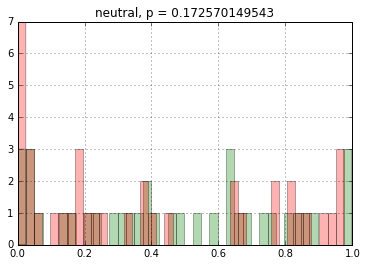

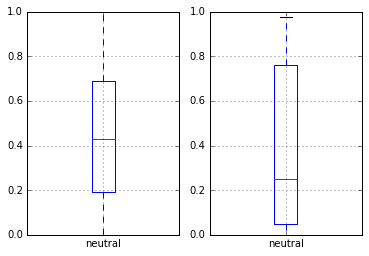

TRUTH median:  0.4302686567164179
BLUFF median:  0.24939855653568566
TRUTH mean:  0.4599399214798777
BLUFF mean:  0.3917135824231662


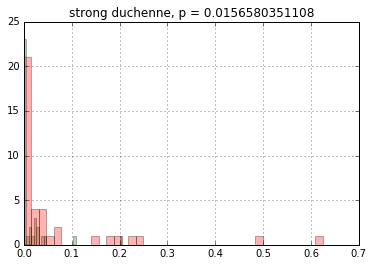

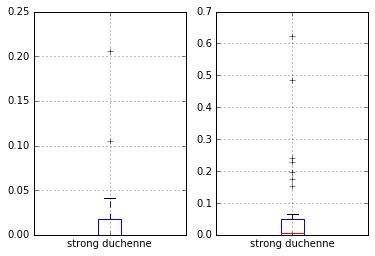

TRUTH median:  0.0
BLUFF median:  0.007102272727272727
TRUTH mean:  0.015718281973938864
BLUFF mean:  0.06571523900862429


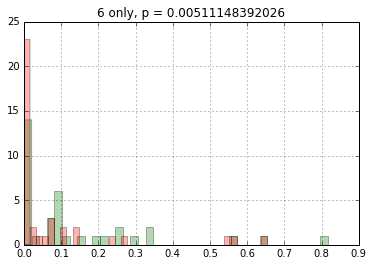

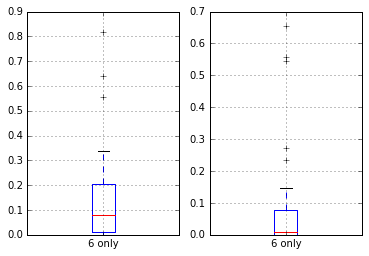

TRUTH median:  0.07829264241820295
BLUFF median:  0.008379888268156424
TRUTH mean:  0.14067858656000087
BLUFF mean:  0.08204160053349686


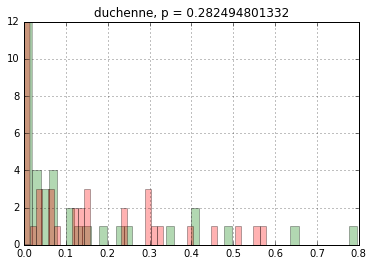

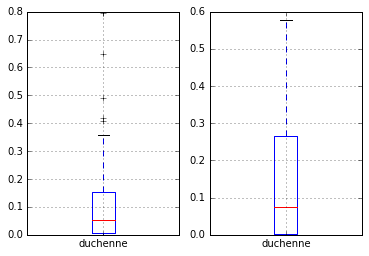

TRUTH median:  0.05190820846569426
BLUFF median:  0.07381889763779527
TRUTH mean:  0.1338497039124473
BLUFF mean:  0.15044465588023584


In [27]:
hist_stats(df_kmm_gr,'polite')
hist_stats(df_kmm_gr,'neutral')
hist_stats(df_kmm_gr,'strong duchenne')
hist_stats(df_kmm_gr,'6 only')
hist_stats(df_kmm_gr,'duchenne')

In [31]:
import matplotlib.pyplot as py
def scatterplot (df,x,y,witness=3):
    if witness <3 :
        a=df[(df['witness_is_male'] == witness) & (df['describer_job_is_truth'] == 1)]
        b=df[(df['witness_is_male'] == witness) & (df['describer_job_is_truth'] == 0)]
        
    else :
        #a=df[(df['describer_job_is_truth'] == 1)]
        #b=df[(df['describer_job_is_truth'] == 0)]
        
        a=df[(df['witness_is_male'] == 1)]
        b=df[(df['witness_is_male'] == 0)]
        
    true=py.scatter(a[x],a[y],color='green',marker = 'x')
    false=py.scatter(b[x],b[y],color='red', marker ='o')
    plt.legend((true,false),('true','bluff'),loc='top right',fontsize=15)
    plt.xlabel(x, fontsize=18)
    plt.ylabel(y, fontsize=16)

    plt.show()
    

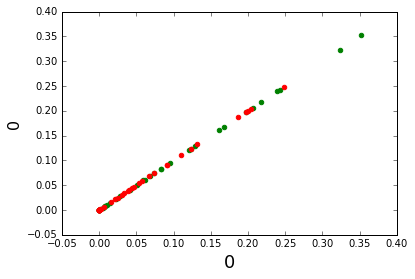

In [24]:
scatterplot(df_bmm9_gr,'0','0',1)

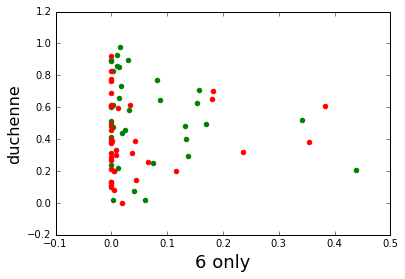

In [9]:
scatterplot(df_bmm_gr,'6 only','duchenne',1)

### Distribution of combination of 2 clusters 

Not differentiating by gender

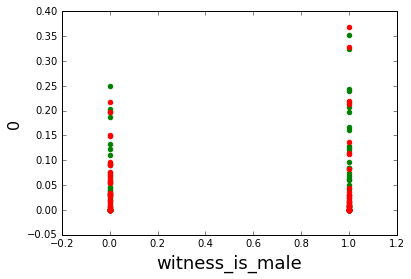

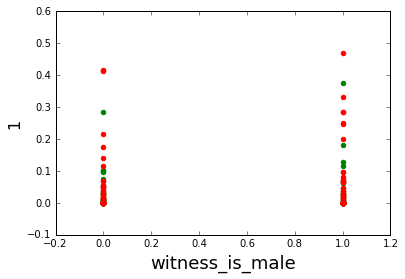

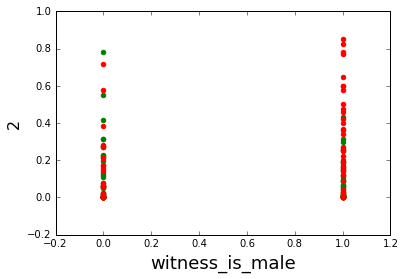

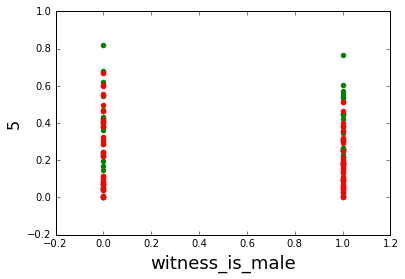

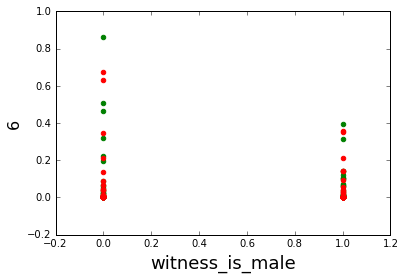

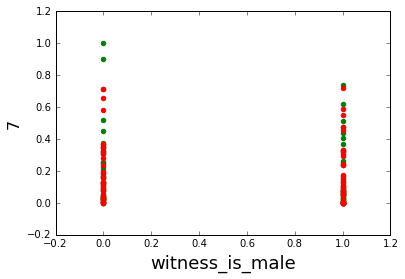

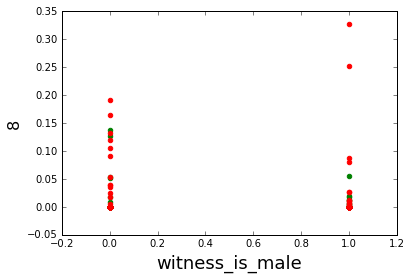

In [12]:
rel = ['0','1','2','5','6','7','8']
for r in rel:
    scatterplot(df_bmm9_gr,'witness_is_male',r)

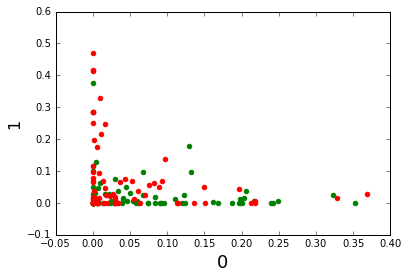

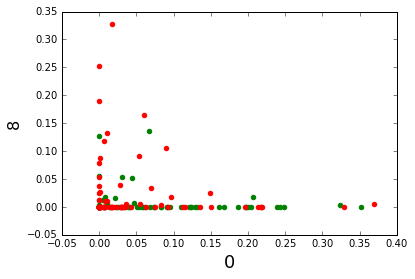

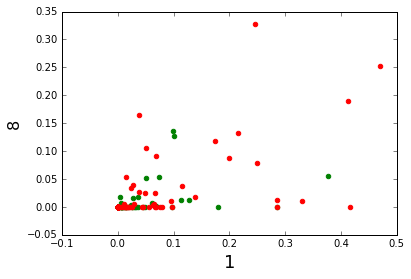

In [13]:
rel = ['0','1','8']
count = -1
for r in rel:
    count = count+1
    for x in range(count,len(rel)):
        if rel[x]!=r:
            scatterplot(df_bmm9_gr,r,rel[x])

Looking at Male witnesses only

C:\Program Files\Anaconda3\lib\site-packages\matplotlib\legend.py:325: UserWarning: Unrecognized location "top right". Falling back on "best"; valid locations are
	upper right
	best
	upper left
	center
	center left
	upper center
	lower left
	lower center
	right
	center right
	lower right

  six.iterkeys(self.codes))))


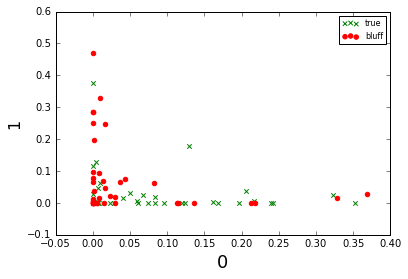

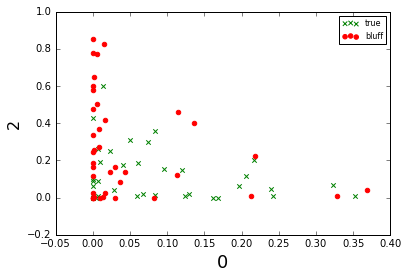

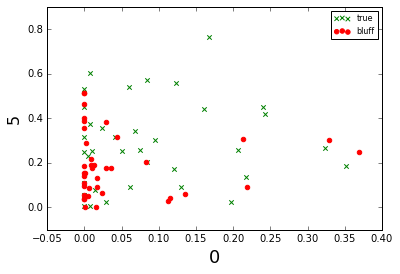

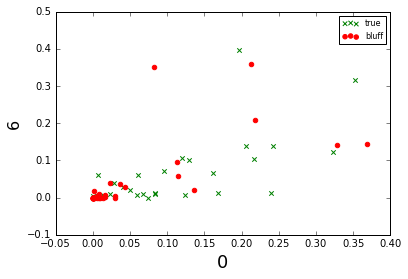

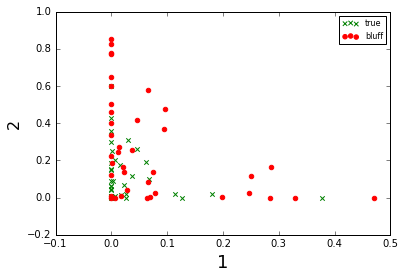

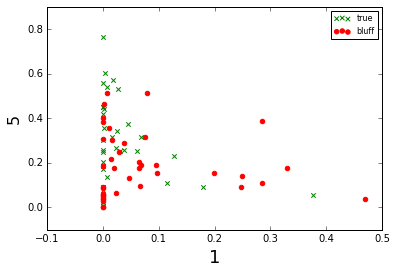

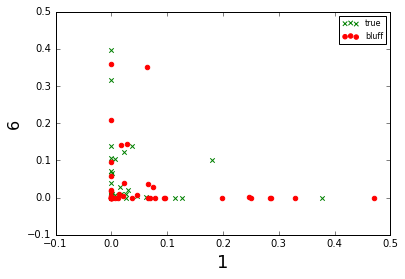

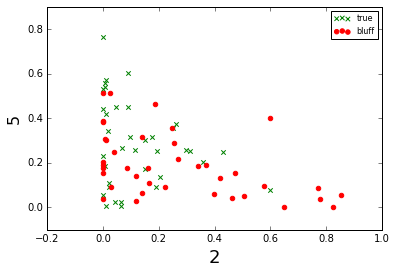

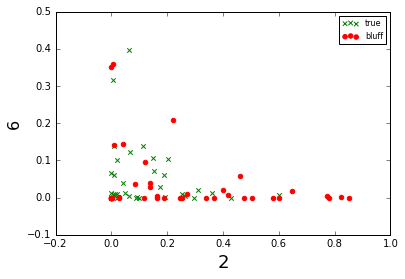

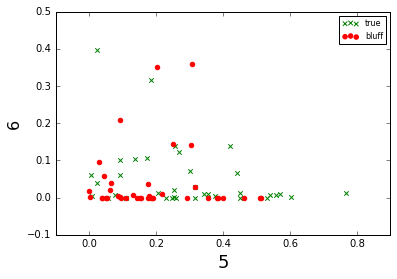

In [29]:
rel = ['0','1','2','5','6']
count = -1
for r in rel:
    count = count+1
    for x in range(count,len(rel)):
        if rel[x]!=r:
            scatterplot(df_bmm9_gr,r,rel[x],1)

C:\Program Files\Anaconda3\lib\site-packages\matplotlib\legend.py:325: UserWarning: Unrecognized location "top right". Falling back on "best"; valid locations are
	upper right
	best
	upper left
	center
	center left
	upper center
	lower left
	lower center
	right
	center right
	lower right

  six.iterkeys(self.codes))))


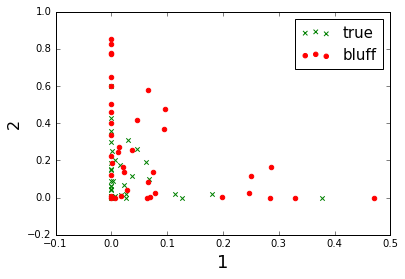

In [32]:
#subset of male and cluster 1 & 2 only
rel = ['1','2']
count = -1
for r in rel:
    count = count+1
    for x in range(count,len(rel)):
        if rel[x]!=r:
            scatterplot(df_bmm9_gr,r,rel[x],1)

C:\Program Files\Anaconda3\lib\site-packages\matplotlib\legend.py:325: UserWarning: Unrecognized location "top right". Falling back on "best"; valid locations are
	upper right
	best
	upper left
	center
	center left
	upper center
	lower left
	lower center
	right
	center right
	lower right

  six.iterkeys(self.codes))))


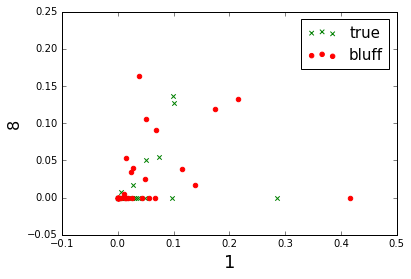

In [34]:
#subset of female witnesses with cluster 1 & 8
rel = ['1','8']
count = -1
for r in rel:
    count = count+1
    for x in range(count,len(rel)):
        if rel[x]!=r:
            scatterplot(df_bmm9_gr,r,rel[x],0)